# XGBoost

In [66]:
import xgboost as xgb
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [212]:
data = pd.read_csv("../../../Data/Dataset_v2.csv",sep=";")

data.columns

Index(['name', 'price', 'province', 'city', 'address', 'type_of_property',
       'floor_size', 'bathrooms', 'pool', 'security', 'health',
       'food_and_entertainment', 'shopping', 'sports_and_leisure', 'levies',
       'rates_and_taxes', 'pets_allowed', 'bedrooms', 'kitchens', 'education',
       'transport_and_public_services', 'garage', 'gardens', 'sampling'],
      dtype='object')

### Get feature categories

In [213]:
def categorisation(data,target="price"):
    distance = []
    numerique = []
    categorique = []
    for col in data.columns:
        if data[col].dtypes == np.object:
            try:
                if str(type(eval(data[col][data[col].first_valid_index()]))) == "<class 'list'>":
                    distance.append(col)
                else:
                    categorique.append(col)
            except:
                categorique.append(col)
                
            
        else :
            if col != target:
                numerique.append(col)
                
    return dict({"numerique":numerique,"categorique":categorique,"distance":distance})

feat_cat = categorisation(data)

feat_cat

C:\Users\USER\AppData\Local\Temp/ipykernel_3100/3923361036.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[col].dtypes == np.object:


{'numerique': ['floor_size',
  'bathrooms',
  'levies',
  'rates_and_taxes',
  'bedrooms',
  'kitchens',
  'gardens',
  'sampling'],
 'categorique': ['name',
  'province',
  'city',
  'address',
  'type_of_property',
  'pool',
  'security',
  'pets_allowed',
  'garage'],
 'distance': ['health',
  'food_and_entertainment',
  'shopping',
  'sports_and_leisure',
  'education',
  'transport_and_public_services']}

### Missing value overview

In [214]:
data.isna().sum()

name                                 0
price                                0
province                             0
city                                 0
address                              0
type_of_property                     0
floor_size                        5729
bathrooms                         1796
pool                             10259
security                          7810
health                            8318
food_and_entertainment            4900
shopping                          8599
sports_and_leisure                6690
levies                            7315
rates_and_taxes                   5012
pets_allowed                      6570
bedrooms                          1497
kitchens                          8646
education                          356
transport_and_public_services     1791
garage                            6461
gardens                          12149
sampling                             0
dtype: int64

In [215]:
len(data['city'].unique())

409

### Dropping name, address and city because there is high cardinality (cf EDA)

In [216]:
data= data.drop(['name','address','city','gardens','pets_allowed','security'],axis=1)
data.columns

Index(['price', 'province', 'type_of_property', 'floor_size', 'bathrooms',
       'pool', 'health', 'food_and_entertainment', 'shopping',
       'sports_and_leisure', 'levies', 'rates_and_taxes', 'bedrooms',
       'kitchens', 'education', 'transport_and_public_services', 'garage',
       'sampling'],
      dtype='object')

## Categorical feature engineering

In [217]:
feat_cat= categorisation(data)
feat_cat["categorique"]

C:\Users\USER\AppData\Local\Temp/ipykernel_3100/3923361036.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[col].dtypes == np.object:


['province', 'type_of_property', 'pool', 'garage']

In [218]:
no_garage = []
for v in data["garage"].unique():
    if str(v)!="nan":
        if "0.0" in v or "NO" in v :
            no_garage.append(v)

In [219]:
for col in feat_cat["categorique"]:
    if col == "pool":
        data[col] = data[col].replace(r"Not Functional",np.nan,regex=True)
        data[col] = data[col].replace(r"Not in working condition - leaking",np.nan,regex=True)
        data[col] = data[col].replace(np.nan,"0")
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace(np.nan,1.)
        data[col][data[col]>1.] = 1.

    elif col == "garage":
        data[col] = data[col].replace(no_garage,np.nan,regex=True)
        data[col] = data[col].replace(np.nan,"0")
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace(np.nan,1.)
        data[col][data[col]>1.] = 1.
    else :
        pass

C:\Users\USER\AppData\Local\Temp/ipykernel_3100/1399750347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][data[col]>1.] = 1.
C:\Users\USER\AppData\Local\Temp/ipykernel_3100/1399750347.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][data[col]>1.] = 1.


In [220]:
data["pool"].unique()

array([1., 0.])

In [221]:
data["garage"].unique()

array([0., 1.])

## Numeric Feature engineering 

### Transform distance features to lenght of list

In [222]:
class transfo_distance:
    def __init__(self,data,features=None):
        self.data = data
        self.method = None
        ### Get features
        self.distance=[]
        if features is None:
            for col in data.columns:
                if data[col].dtypes == np.object:
                    try:
                        if str(type(eval(data[col][data[col].first_valid_index()]))) == "<class 'list'>":
                            self.distance.append(col)
                    except:
                        pass
        else:
            distance=features
        
        ###Transformations : "mean", "median", "max", "min", "len"
    def transformation(self,method):
        self.method = method
        for feat in self.distance:
            serie = []
            for i in data[feat]:
                if str(i) != "nan":
                    serie.append(self.checker(i))
                else :
                    serie.append(np.nan)
            self.data[feat] = serie
            
    def checker(self,value):
        if self.method=="mean":
            return (np.array(eval(value))).mean()
        elif self.method =="median":
            return (np.array(eval(value))).mediane()
        elif self.method =="min":
            return (np.array(eval(value))).min()
        elif self.method =="max":
            return (np.array(eval(value))).max()
        elif self.method =="len":
            return float(len(eval(value)))
        else:
            raise('choose correct method : "mean", "median", "max", "min", "len"')
    
    def get_data(self,method="mean"):
        self.transformation(method)
        return self.data

In [223]:
trans_dist = transfo_distance(data)
data = trans_dist.get_data(method="len")
data.shape

C:\Users\USER\AppData\Local\Temp/ipykernel_3100/2201901570.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[col].dtypes == np.object:


(13666, 18)

In [224]:
data= data[~(data['type_of_property'] == 'Vacant Land / Plot')]
data.shape

(13665, 18)

#### Ampute missing by 0

In [225]:
data[feat_cat["distance"]] = data[feat_cat["distance"]].fillna(0)

C:\Users\USER\Anaconda3\envs\deepai\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Check lenght of distances vs price

C:\Users\USER\Anaconda3\envs\deepai\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


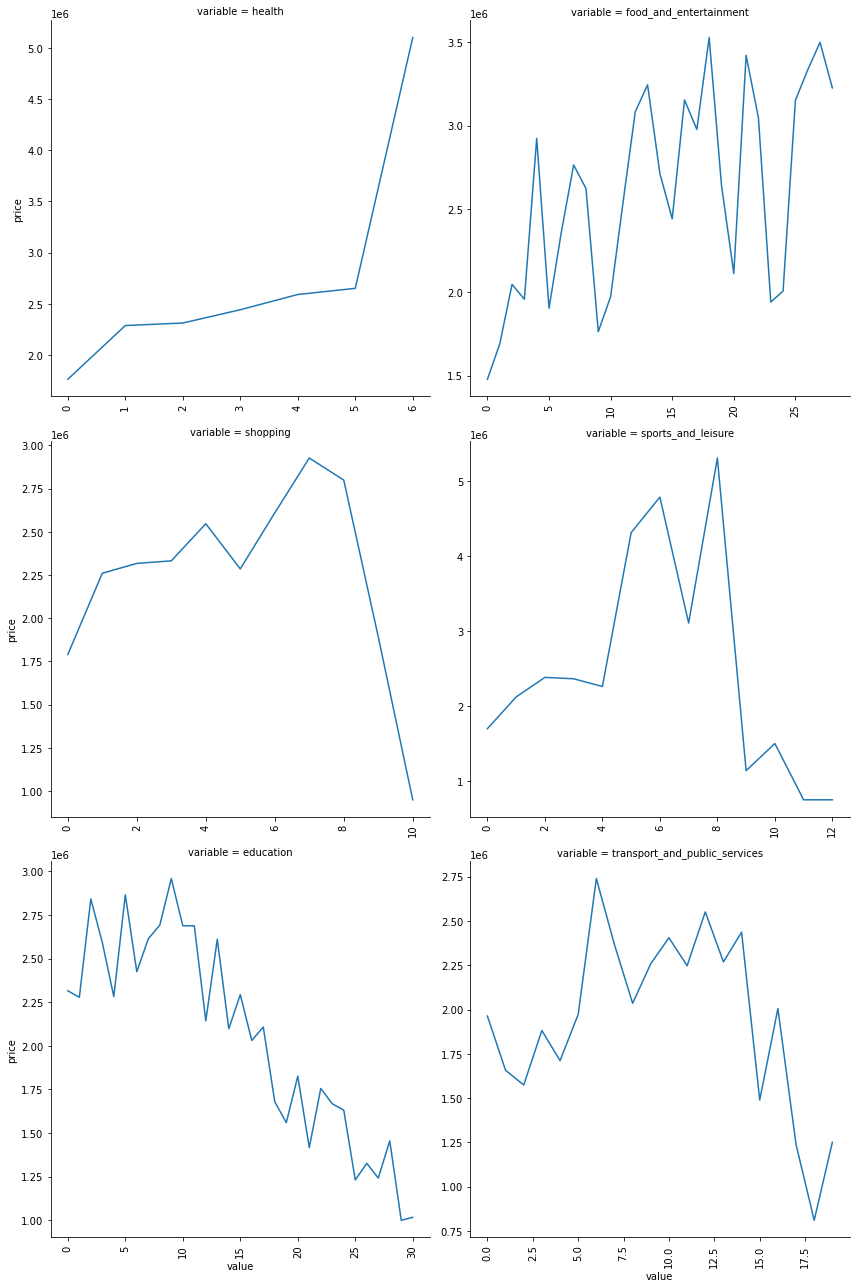

In [226]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
feats = feat_cat["distance"]
f = pd.melt(data, id_vars=['price'], value_vars=feats)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=6)
g = g.map(pairplot, "value", "price")

In [228]:
data= data.drop(['sports_and_leisure'],axis=1)

KeyError: "['sports_and_leisure'] not found in axis"

### Ampute missing by 1 for bedrooms, kitchens, bathrooms (We suppose there are one at least)

In [229]:
data[["bedrooms", "kitchens", "bathrooms"]] = data[["bedrooms", "kitchens", "bathrooms"]].fillna(1.)

### Ampute missing by median for floor size, levies, rates_and_taxes by province

In [237]:
# data[["floor_size", "levies", "rates_and_taxes"]] = data[["floor_size", "levies", "rates_and_taxes"]].fillna(data[["floor_size", "levies", "rates_and_taxes"]].median())

provinces= data['province'].unique()
print("floor size mean: ",data["floor_size"].mean(), "floor size median: ",data["floor_size"].median())
print("levies mean: ",data["levies"].mean(), "levies median: ",data["levies"].median())
print("rates and taxes mean: ",data["rates_and_taxes"].mean(), "rates and taxes median: ",data["rates_and_taxes"].median())

for prov in provinces:
    print(prov)
    print("floor size mean: ",data[data['province']==prov]["floor_size"].mean(), "floor size median: ",data[data['province']==prov]["floor_size"].median())
    print("levies mean: ",data[data['province']==prov]["levies"].mean(), "levies median: ",data[data['province']==prov]["levies"].median())
    print("rates and taxes mean: ",data[data['province']==prov]["rates_and_taxes"].mean(), "rates and taxes median: ",data[data['province']==prov]["rates_and_taxes"].median())

    data[data['province']==prov] = data[data['province']==prov].fillna({"floor_size": data[data['province']==prov]["floor_size"].median()})
    data[data['province']==prov] = data[data['province']==prov].fillna({"levies": data[data['province']==prov]["levies"].median()})
    data[data['province']==prov] = data[data['province']==prov].fillna({"rates_and_taxes": data[data['province']==prov]["rates_and_taxes"].median()})

floor size mean:  216.11076108870967 floor size median:  106.0
levies mean:  1731.8312076838292 levies median:  1500.0
rates and taxes mean:  1055.7071535883508 rates and taxes median:  773.0
kwazulu-natal
floor size mean:  183.72924747866563 floor size median:  120.0
levies mean:  2033.8132854578098 levies median:  1800.0
rates and taxes mean:  1360.2089965397925 rates and taxes median:  1000.0
eastern-cape
floor size mean:  205.05944055944056 floor size median:  157.0
levies mean:  1290.2191011235955 levies median:  1160.0
rates and taxes mean:  1218.1339563862928 rates and taxes median:  884.0
gauteng
floor size mean:  249.08310325786857 floor size median:  96.0
levies mean:  1762.759612169843 levies median:  1570.0
rates and taxes mean:  976.4726331360947 rates and taxes median:  650.0
north-west
floor size mean:  183.62545454545455 floor size median:  101.0
levies mean:  1164.6389452332658 levies median:  897.0
rates and taxes mean:  768.815 rates and taxes median:  600.0
western-

In [238]:
data[data['province']=='gauteng']["floor_size"]

3         96.0
6         70.0
7         64.0
11       149.0
13        60.0
         ...  
13656     56.0
13659     96.0
13661     75.0
13664     96.0
13665     96.0
Name: floor_size, Length: 6149, dtype: float64

In [239]:
feat_cat = categorisation(data,["Listing Date"])
feat_cat

C:\Users\USER\AppData\Local\Temp/ipykernel_3100/3923361036.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[col].dtypes == np.object:


{'numerique': ['price',
  'floor_size',
  'bathrooms',
  'pool',
  'health',
  'food_and_entertainment',
  'shopping',
  'levies',
  'rates_and_taxes',
  'bedrooms',
  'kitchens',
  'education',
  'transport_and_public_services',
  'garage',
  'sampling'],
 'categorique': ['province', 'type_of_property'],
 'distance': []}

## Encoding cadegorical data

### Using LabelEncoder

In [54]:
def label_encoding(data,labels):
    for label in labels:
        label_encoder= LabelEncoder()
        data[label]=label_encoder.fit_transform(data[label])
    return data

### Using dummies

In [88]:
def using_dummies(data):
    return pd.get_dummies(data)

### Using custom label encoding

In [56]:
def label_custom_encoding(data,labels):
    for label in labels:
        values= data[label].unique()
        for value in values:
            code= len(data[data[label]==value])
            data.loc[data[label]==value,label]=int(code)
        data[label]=pd.to_numeric(data[label])
    return data

### target mean ordering encoding of categorical value

In [122]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'price']].groupby(feature).mean()['price']
    #print(frame[[feature, 'a']].groupby(feature).mean()['a'])
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering)
    ordering = ordering['ordering'].to_dict()
    #print(ordering)
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [240]:
# data= using_dummies(data)

qual_encoded = []
feat_cat = categorisation(data)
for q in feat_cat["categorique"]:  
    encode(data, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)


# data= label_custom_encoding(data,feat_cat['categorique'])

# data= label_encoding(data,feat_cat['categorique'])


['province_E', 'type_of_property_E']


C:\Users\USER\AppData\Local\Temp/ipykernel_3100/3923361036.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[col].dtypes == np.object:


### Sampling

In [241]:
def split_data(data,target,col="sampling",features_to_keep=None):
    if features_to_keep is not None :
        features_to_keep = features_to_keep + [target]
        data = data[features_to_keep]
        
    unique = data["sampling"].unique()
    for i, v in enumerate(unique):
        if v == 1 :
            data_train = data[data[col]==v]
            y_train = data_train[target]
            X_train = data_train.drop([target,"sampling"],axis=1)
            print("train shape :",X_train.shape)
        elif v == 2 :
            data_val = data[data[col]==v]
            y_val = data_val[target]
            X_val = data_val.drop([target,"sampling"],axis=1)
            print("val shape :",X_val.shape)
        elif v == 3 :
            data_test = data[data[col]==v]
            y_test = data_test[target]
            X_test = data_test.drop([target,"sampling"],axis=1)
            print("test shape :",X_test.shape)
    
            
    return X_train, np.log(y_train), X_val, np.log(y_val), X_test, np.log(y_test)

In [242]:
data.columns

Index(['price', 'province', 'type_of_property', 'floor_size', 'bathrooms',
       'pool', 'health', 'food_and_entertainment', 'shopping', 'levies',
       'rates_and_taxes', 'bedrooms', 'kitchens', 'education',
       'transport_and_public_services', 'garage', 'sampling', 'province_E',
       'type_of_property_E'],
      dtype='object')

In [243]:
feats=[ 'floor_size', 'bathrooms',
       'pool', 'health', 'food_and_entertainment', 'shopping', 'levies',
       'rates_and_taxes', 'bedrooms', 'kitchens', 'education',
       'transport_and_public_services', 'garage', 'sampling', 'province_E',
       'type_of_property_E']

In [244]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data,"price",features_to_keep=feats)
# X_train, y_train, X_val, y_val, X_test, y_test = split_data(data,"price")
data.shape

train shape : (9563, 15)
val shape : (2053, 15)
test shape : (2049, 15)


(13665, 19)

In [245]:
reg = xgb.XGBRegressor(n_jobs=2)
reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [246]:
y_prediction =  reg.predict(X_val)
y_prediction

C:\Users\USER\Anaconda3\envs\deepai\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


array([12.994758, 14.726112, 13.537587, ..., 14.896887, 13.884101,
       13.618067], dtype=float32)

In [247]:
rmse = np.sqrt(mean_squared_error(y_val, reg.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

The Root mean squared error (RMSE) on val set: 0.3837
The Root mean squared error (RMSE) on train set: 0.2647


C:\Users\USER\Anaconda3\envs\deepai\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [249]:
print("Model : RF")

RF = RandomForestRegressor()
RF.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, RF.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, RF.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

print("Model : RidgeCV")

regCV = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
regCV.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, regCV.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, regCV.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

print("Model : SVR")

regr = SVR(C=1.0,epsilon=0.2)
regr.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, regr.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, regr.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))


print("Model : Multi Linear Regression")

reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)

rmse = np.sqrt(mean_squared_error(y_val, reg.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

Model : RF
The Root mean squared error (RMSE) on val set: 0.3974
The Root mean squared error (RMSE) on train set: 0.1712
Model : RidgeCV
The Root mean squared error (RMSE) on val set: 0.4711
The Root mean squared error (RMSE) on train set: 0.4864
Model : SVR
The Root mean squared error (RMSE) on val set: 0.5467
The Root mean squared error (RMSE) on train set: 0.5653
Model : Multi Linear Regression
The Root mean squared error (RMSE) on val set: 0.4711
The Root mean squared error (RMSE) on train set: 0.4864
